Whitney Schreiber

Nick Petr

MScA 31013 Optimization and Simulation Methods

Final Project, Summer 2022

# Multi-Criteria Manufacturing Optimization 

```
import Pkg;
Pkg.add("JuMP")
Pkg.add("NLopt")
```

## Objective 

Our company produces a tool used within various machines in car production lines. This tool requires two unique parts to produce (Part A, Part B), which are developed using two natural components (raw material 1, raw material 2). Raw material 1 and raw material 2 are used in the production of both Part A and Part B. We are hoping to minimize production costs and maximize profits in the development of this tool. We are also hoping to minimize the number of employees per shift required to produce this tool.

## Variable definitions 

Raw material:
- $a_1$, quantity of raw material 1
- $a_2$, quantity of raw material 2

Costs:
- $r_1$, cost per unit of raw material 1
- $r_2$, cost per unit of raw material 2
- $w_A$, machinery cost for producing one Part A
- $w_B$, machinery cost for producing one Part B
- $w_L$, wages for one laborer per shift

Selling prices:
- $p_E$, final product (engine) market price
- $p_A$, Part A market price
- $p_B$, Part B market price

**Decision Variables** (production and allocation of Parts A and B):
- $x_1$, units of Part A allocated to building final product
- $x_2$, units of Part B allocated to building final product
- $x_3$, units of Part A sold in market
- $x_4$, units of Part B sold in market

## Production Requirements:

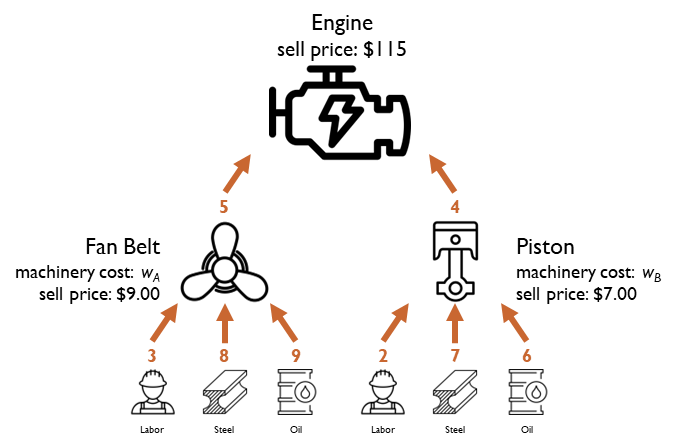

- Fan Belt (Part A):
    - 8 units of Steel (raw material 1)
    - 9 units of Oil (raw material 2)
    - 3 laborers
    - machinery cost of $w_A$
- Piston (Part B):
    - 7 units of Steel (raw material 1)
    - 6 units of Oil (raw material 2)
    - 2 laborers
    - machinery cost of $w_B$
- Engine (Final Tool):
    - 5 Fan Belts (Part A)
    - 4 Pistons (Part B)

## Costs

#### Cost per Part A

- raw material cost: 
    - $8*r_1 + 9*r_2$
- labor cost:
    - $3 * w_L$
- manufacturing cost:
    - $w_A$
- **Part A Total Production Cost/Unit:**
    - $c_A = 8*r_1 + 9*r_2 + 3*w_L + w_A$


#### Cost per Part B

- raw material cost:
    - $7*r_1 + 6*r_2$
- labor cost:
    - $2 * w_L$
- manufacturing cost:
    - $w_B$
- **Part B Total Production Cost/Unit:**
    - $c_B = 7*r_1 + 6*r_2 + 2*w_L + w_B$

#### Cost per Final Product
- **$c_E = 5*c_A + 4*c_B$**


## Profit

$\pi = Total Revenue - Total Cost = \frac{price}{unit}*quantity - \frac{cost}{unit}*quanity $

$\pi = \pi_{final product} + \pi_{indiv Part A} + \pi_{indiv Part B} = (p_E-c_E)*(\frac{(\frac{x_1}{5}+\frac{x_2}{4})}{2}) + (p_A-c_A)*x3 + (p_B-c_B)*x4$

--------------------

## Optimization Problem, Variation I (Basic Solution)

*Maximize Profit*

*Determine:*
- *quantities of Part A, Part B and Final Product that maximize profit,*
- *quantity of raw material to purchase, and* 
- *required labor*

### *Constraints I*

#### Availability of Raw Material:
- An unlimited supply of raw material 1 ($a_1$) is available for purchase
- An unlimited supply of raw material 2 ($a_2$) is available for purchase

#### Factory Personale (Labor) Capacity:
- The factory can accomodate 250 laborers working at a given time

#### Production Cost Constraints:
- *Assume no manufacturing cost constraint*

In [1]:
#----------
# initialize variables
#----------
r1 = 0.10       # raw material 1 cost per unit
r2 = 0.20       # raw material 2 cost per unit
wA = 0.15       # machinery cost/Part A
wB = 0.25       # machinery cost/Part B
wL = 1.7        # labor cost per employee per shift
cA = 8*r1 + 9*r2 + 3*wL + wA  # total cost/Part A
cB = 7*r1 + 6*r2 + 2*wL + wB  # total cost/Part B
cE = 5*cA + 4*cB              # total cost to assemble one final tool
pE = 115        # final product market price
pA = 9          # Part A market price
pB = 7          # Part B market price

print("Unit Cost of Part A: ",cA,"\n",
      "Unit Cost of Part B: ",cB,"\n",
      "Unit Cost of Final Product: ",cE)

Unit Cost of Part A: 7.85
Unit Cost of Part B: 5.550000000000001
Unit Cost of Final Product: 61.45

In [2]:
using JuMP, GLPK
model = Model(GLPK.Optimizer)

#----------
# Variables
#----------
# Production and allocation of Parts A & B 
@variable(model, x1 >= 0)  # units of Part A allocated to building final product
@variable(model, x2 >= 0)  # units of Part B allocated to building final product
@variable(model, x3 >= 0)  # units of Part A sold
@variable(model, x4 >= 0)  # units of Part B sold
# Quantity of raw materials
@variable(model, a1 >= 0)
@variable(model, a2 >= 0)

#----------
# Objective function
#----------
@objective(model, Max, (pE-cE)*(((x1/5)+(x2/4))/2) + (pA-cA)*x3 + (pB-cB)*x4)

#----------
# Constraints for the primary optimization problem
#----------
# final product requires 5 units of x1 and 4 units of x2 
@constraint(model, (x1/5) - (x2/4) == 0.0)
# raw material 1 available for manufacturing Parts A and B
@constraint(model, 8*x1 + 7*x2 + 8*x3 + 7*x4 <= a1)
# raw material 2 available for manufacturing Parts A and B
@constraint(model, 9*x1 + 6*x2 + 9*x3 + 6*x4 <= a2)
# factory personale capacity (3 employees/Part A; 2 employees/Part B)
@constraint(model, 3*x1 + 2*x2 + 3*x3 + 2*x4 <= 250)

print(model)
JuMP.optimize!(model)

unitsA = (value(x1)+value(x3))
unitsB = (value(x2)+value(x4))
println("--------------RAW MATERIAL--------------")
println("Raw material 1: purchase ",value(a1)," units for a total of \$",value(a1)*r1)
println("Raw material 2: purchase ",value(a2)," units for a total of \$",value(a2)*r2)
println("\n----------PRODUCTION OF PART A----------")
println("Units of Part A used in final product: ", value(x1))
println("Units of Part A sold individually: ", value(x3))
println("Total units of Part A produced: ", unitsA)
println("Laborers allocated to Part A: ",3*unitsA)
println("Wages allocated to Part A: ",wL*3*unitsA)
println("Raw material cost allocated to Part A: ", unitsA*(8*r1+9*r2))
println("Total variable cost allocated to Part A: ", cA*unitsA)
println("\n----------PRODUCTION OF PART B----------")
println("Units of Part B used in final product: ", value(x2))
println("Units of Part B sold individually: ", value(x4))
println("Total units of Part B produced: ", unitsB)
println("Laborers allocated to Part B: ",2*unitsB)
println("Wages allocated to Part B: ",wL*2*unitsB)
println("Raw material cost allocated to Part B: ", unitsB*(7*r1+6*r2))
println("Total variable cost allocated to Part B: ", unitsB*cB)
println("\n------------TOTAL PRODUCTION------------")
println("Total engines produced: ", (value(x1)/5+value(x2)/4))
println("Total laborers per shift: ", 3*unitsA + 2*unitsB)
println("Total wages: ", wL*(3*unitsA + 2*unitsB))
println("Total cost of raw material: ", unitsA*(8*r1+9*r2) + unitsB*(7*r1+6*r2))
println("Total production cost: ", cA*unitsA + cB*unitsB)
println("\n---------------- PROFIT ----------------")
println("Maximal profit of ", objective_value(model))

--------------RAW MATERIAL--------------
Raw material 1: purchase 739.1304347826087 units for a total of $73.91304347826087
Raw material 2: purchase 750.0 units for a total of $150.0

----------PRODUCTION OF PART A----------
Units of Part A used in final product: 54.34782608695652
Units of Part A sold individually: 0.0
Total units of Part A produced: 54.34782608695652
Laborers allocated to Part A: 163.04347826086956
Wages allocated to Part A: 277.17391304347825
Raw material cost allocated to Part A: 141.30434782608697
Total variable cost allocated to Part A: 426.6304347826087

----------PRODUCTION OF PART B----------
Units of Part B used in final product: 43.478260869565226
Units of Part B sold individually: 0.0
Total units of Part B produced: 43.478260869565226
Laborers allocated to Part B: 86.95652173913045
Wages allocated to Part B: 147.82608695652178
Raw material cost allocated to Part B: 82.60869565217395
Total variable cost allocated to Part B: 241.30434782608702

------------TOT

----------------

## Optimization Problem, Variation II

> ***\> Supply chain shortages cause availability of raw materials (1 & 2) to decrease***

*Maximize Profit*

*Determine:*
- *quantities of Part A, Part B and Final Product that maximize profit,*
- *quantity of raw material to purchase (given availability constraints), and* 
- *required labor*

### *Constraints II*

#### Raw Material Available:
- availability of raw material 1, $a_1$, is limited to 56 units
- availability of raw material 2, $a_2$, is limited to 54 units

#### Factory Personale (Labor) Capacity:¶
- The factory can accomodate 250 laborers working at a given time

#### Production Cost Constraints:
- *Assume no manufacturing cost constraint*

In [3]:
using JuMP, GLPK
model = Model(GLPK.Optimizer)

#----------
# Variables
#----------
# Production and allocation of Parts A & B 
@variable(model, x1 >= 0)  # units of Part A allocated to building final product
@variable(model, x2 >= 0)  # units of Part B allocated to building final product
@variable(model, x3 >= 0)  # units of Part A sold
@variable(model, x4 >= 0)  # units of Part B sold
# Quantity of raw materials
@variable(model, 0 <= a1 <= 56)
@variable(model, 0 <= a2 <= 54)

#----------
# Objective function
#----------
@objective(model, Max, (pE-cE)*(((x1/5)+(x2/4))/2) + (pA-cA)*x3 + (pB-cB)*x4)

#----------
# Constraints for the primary optimization problem
#----------
# final product requires 5 units of x1 and 4 units of x2 
@constraint(model, (x1/5) - (x2/4) == 0.0)
# raw material 1 available for manufacturing Parts A and B
@constraint(model, 8*x1 + 7*x2 + 8*x3 + 7*x4 <= a1)
# raw material 2 available for manufacturing Parts A and B
@constraint(model, 9*x1 + 6*x2 + 9*x3 + 6*x4 <= a2)
# factory personale capacity (3 employees per one Part A; 2 employees per one Part B)
@constraint(model, 3*x1 + 2*x2 + 3*x3 + 2*x4 <= 250)

print(model)
JuMP.optimize!(model)

unitsA = (value(x1)+value(x3))
unitsB = (value(x2)+value(x4))
println("--------------RAW MATERIAL--------------")
println("Raw material 1: purchase ",value(a1)," units for a total of \$",value(a1)*r1)
println("Raw material 2: purchase ",value(a2)," units for a total of \$",value(a2)*r2)
println("\n----------PRODUCTION OF PART A----------")
println("Units of Part A used in final product: ", value(x1))
println("Units of Part A sold individually: ", value(x3))
println("Total units of Part A produced: ", unitsA)
println("Laborers allocated to Part A: ",3*unitsA)
println("Wages allocated to Part A: ",wL*3*unitsA)
println("Raw material cost allocated to Part A: ", unitsA*(8*r1+9*r2))
println("Total variable cost allocated to Part A: ", cA*unitsA)
println("\n----------PRODUCTION OF PART B----------")
println("Units of Part B used in final product: ", value(x2))
println("Units of Part B sold individually: ", value(x4))
println("Total units of Part B produced: ", unitsB)
println("Laborers allocated to Part B: ",2*unitsB)
println("Wages allocated to Part B: ",wL*2*unitsB)
println("Raw material cost allocated to Part B: ", unitsB*(7*r1+6*r2))
println("Total variable cost allocated to Part B: ", unitsB*cB)
println("\n------------TOTAL PRODUCTION------------")
println("Total engines produced: ", (value(x1)/5+value(x2)/4))
println("Total laborers per shift: ", 3*unitsA + 2*unitsB)
println("Total wages: ", wL*(3*unitsA + 2*unitsB))
println("Total cost of raw material: ", unitsA*(8*r1+9*r2) + unitsB*(7*r1+6*r2))
println("Total production cost: ", cA*unitsA + cB*unitsB)
println("\n---------------- PROFIT ----------------")
println("Maximal profit of ", objective_value(model))

--------------RAW MATERIAL--------------
Raw material 1: purchase 53.21739130434782 units for a total of $5.321739130434782
Raw material 2: purchase 54.0 units for a total of $10.8

----------PRODUCTION OF PART A----------
Units of Part A used in final product: 3.91304347826087
Units of Part A sold individually: 0.0
Total units of Part A produced: 3.91304347826087
Laborers allocated to Part A: 11.73913043478261
Wages allocated to Part A: 19.956521739130437
Raw material cost allocated to Part A: 10.173913043478262
Total variable cost allocated to Part A: 30.717391304347828

----------PRODUCTION OF PART B----------
Units of Part B used in final product: 3.1304347826086945
Units of Part B sold individually: 0.0
Total units of Part B produced: 3.1304347826086945
Laborers allocated to Part B: 6.260869565217389
Wages allocated to Part B: 10.64347826086956
Raw material cost allocated to Part B: 5.94782608695652
Total variable cost allocated to Part B: 17.373913043478257

------------TOTAL PRO

----------------
## Optimization Problem, Variation III

> \> ***Supply chain shortages cause availability of raw materials (1 & 2) to decrease***

> \>> ***Covid restrictions cause factory capacity to shrink***

*Maximize Profit*

*Determine:*
- *quantities of Part A, Part B and Final Product that maximize profit,*
- *quantity of raw material to purchase (given availability constraints), and* 
- *required labor (given capacity constraints)*

## *Constraints III*

#### Raw Material Available:
- availability of raw material 1, $a_1$, is limited to 56 units
- availability of raw material 2, $a_2$, is limited to 54 units

#### Factory Personale (Labor) Capacity:¶
- Personale capacity is limited to 47 laborers per shift

#### Production Cost Constraints:
- *Assume no manufacturing cost constraint*

In [4]:
using JuMP, GLPK
model = Model(GLPK.Optimizer)

#----------
# Variables
#----------
# Production and allocation of Parts A & B 
@variable(model, x1 >= 0)  # units of Part A allocated to building final product
@variable(model, x2 >= 0)  # units of Part B allocated to building final product
@variable(model, x3 >= 0)  # units of Part A sold
@variable(model, x4 >= 0)  # units of Part B sold
# Quantity of raw materials
@variable(model, 0 <= a1 <= 56)
@variable(model, 0 <= a2 <= 54)

#----------
# Objective function
#----------
@objective(model, Max, (pE-cE)*(((x1/5)+(x2/4))/2) + (pA-cA)*x3 + (pB-cB)*x4)

#----------
# Constraints for the primary optimization problem
#----------
# final product requires 5 units of x1 and 4 units of x2 
@constraint(model, (x1/5) - (x2/4) == 0.0)
# raw material 1 available for manufacturing Parts A and B
@constraint(model, 8*x1 + 7*x2 + 8*x3 + 7*x4 <= a1)
# raw material 2 available for manufacturing Parts A and B
@constraint(model, 9*x1 + 6*x2 + 9*x3 + 6*x4 <= a2)
# factory personale capacity (3 employees/Part A; 2 employees/Part B)
@constraint(model, 3*x1 + 2*x2 + 3*x3 + 2*x4 <= 47)

print(model)
JuMP.optimize!(model)

unitsA = (value(x1)+value(x3))
unitsB = (value(x2)+value(x4))
println("--------------RAW MATERIAL--------------")
println("Raw material 1: purchase ",value(a1)," units for a total of \$",value(a1)*r1)
println("Raw material 2: purchase ",value(a2)," units for a total of \$",value(a2)*r2)
println("\n----------PRODUCTION OF PART A----------")
println("Units of Part A used in final product: ", value(x1))
println("Units of Part A sold individually: ", value(x3))
println("Total units of Part A produced: ", unitsA)
println("Laborers allocated to Part A: ",3*unitsA)
println("Wages allocated to Part A: ",wL*3*unitsA)
println("Raw material cost allocated to Part A: ", unitsA*(8*r1+9*r2))
println("Total variable cost allocated to Part A: ", cA*unitsA)
println("\n----------PRODUCTION OF PART B----------")
println("Units of Part B used in final product: ", value(x2))
println("Units of Part B sold individually: ", value(x4))
println("Total units of Part B produced: ", unitsB)
println("Laborers allocated to Part B: ",2*unitsB)
println("Wages allocated to Part B: ",wL*2*unitsB)
println("Raw material cost allocated to Part B: ", unitsB*(7*r1+6*r2))
println("Total variable cost allocated to Part B: ", unitsB*cB)
println("\n------------TOTAL PRODUCTION------------")
println("Total engines produced: ", (value(x1)/5+value(x2)/4))
println("Total laborers per shift: ", 3*unitsA + 2*unitsB)
println("Total wages: ", wL*(3*unitsA + 2*unitsB))
println("Total cost of raw material: ", unitsA*(8*r1+9*r2) + unitsB*(7*r1+6*r2))
println("Total production cost: ", cA*unitsA + cB*unitsB)
println("\n---------------- PROFIT ----------------")
println("Maximal profit of ", objective_value(model))

--------------RAW MATERIAL--------------
Raw material 1: purchase 53.21739130434782 units for a total of $5.321739130434782
Raw material 2: purchase 54.0 units for a total of $10.8

----------PRODUCTION OF PART A----------
Units of Part A used in final product: 3.91304347826087
Units of Part A sold individually: 0.0
Total units of Part A produced: 3.91304347826087
Laborers allocated to Part A: 11.73913043478261
Wages allocated to Part A: 19.956521739130437
Raw material cost allocated to Part A: 10.173913043478262
Total variable cost allocated to Part A: 30.717391304347828

----------PRODUCTION OF PART B----------
Units of Part B used in final product: 3.1304347826086945
Units of Part B sold individually: 0.0
Total units of Part B produced: 3.1304347826086945
Laborers allocated to Part B: 6.260869565217389
Wages allocated to Part B: 10.64347826086956
Raw material cost allocated to Part B: 5.94782608695652
Total variable cost allocated to Part B: 17.373913043478257

------------TOTAL PRO

----------------
## Optimization Problem, Variation IV

> \> ***Supply chain shortages cause availability of raw materials (1 & 2) to decrease***

> \>> ***Covid restrictions cause factory capacity to shrink***

> \>>> ***Due to liquidity constraints, the company must limit total production costs***

*Maximize Profit*

*Determine:*
- *quantities of Part A, Part B and Final Product that maximize profit,*
- *quantity of raw material to purchase (given availability constraints), and* 
- *required labor (given capacity constraints)*

## *Constraints IV*

#### Raw Material Available:
- availability of raw material 1, $a_1$, is limited to 56 units
- availability of raw material 2, $a_2$, is limited to 54 units

#### Factory Personale (Labor) Capacity:¶
- Personale capacity is limited to 47 laborers per shift

#### Production Cost Constraints:
- Total production cost must not exceed $45

In [5]:
using JuMP, GLPK
model = Model(GLPK.Optimizer)

#----------
# Variables
#----------
# Production and allocation of Parts A & B 
@variable(model, x1 >= 0)  # units of Part A allocated to building final product
@variable(model, x2 >= 0)  # units of Part B allocated to building final product
@variable(model, x3 >= 0)  # units of Part A sold
@variable(model, x4 >= 0)  # units of Part B sold
# Quantity of raw materials
@variable(model, 0 <= a1 <= 56)
@variable(model, 0 <= a2 <= 54)

#----------
# Objective function
#----------
@objective(model, Max, (pE-cE)*(((x1/5)+(x2/4))/2) + (pA-cA)*x3 + (pB-cB)*x4)

#----------
# Constraints for the primary optimization problem
#----------
# final product requires 5 units of x1 and 4 units of x2 
@constraint(model, (x1/5) - (x2/4) == 0.0)
# raw material 1 available for manufacturing Parts A and B
@constraint(model, 8*x1 + 7*x2 + 8*x3 + 7*x4 <= a1)
# raw material 2 available for manufacturing Parts A and B
@constraint(model, 9*x1 + 6*x2 + 9*x3 + 6*x4 <= a2)
# factory personale capacity (3 employees per one Part A; 2 employees per one Part B)
@constraint(model, 3*x1 + 2*x2 + 3*x3 + 2*x4 <= 47)
# cannot exceed $45 in production costs of Parts A and B
@constraint(model, cA*(x1+x3) + cB*(x2+x4) <= 45)

print(model)
JuMP.optimize!(model)

unitsA = (value(x1)+value(x3))
unitsB = (value(x2)+value(x4))
println("--------------RAW MATERIAL--------------")
println("Raw material 1: purchase ",value(a1)," units for a total of \$",value(a1)*r1)
println("Raw material 2: purchase ",value(a2)," units for a total of \$",value(a2)*r2)
println("\n----------PRODUCTION OF PART A----------")
println("Units of Part A used in final product: ", value(x1))
println("Units of Part A sold individually: ", value(x3))
println("Total units of Part A produced: ", unitsA)
println("Laborers allocated to Part A: ",3*unitsA)
println("Wages allocated to Part A: ",wL*3*unitsA)
println("Raw material cost allocated to Part A: ", unitsA*(8*r1+9*r2))
println("Total variable cost allocated to Part A: ", cA*unitsA)
println("\n----------PRODUCTION OF PART B----------")
println("Units of Part B used in final product: ", value(x2))
println("Units of Part B sold individually: ", value(x4))
println("Total units of Part B produced: ", unitsB)
println("Laborers allocated to Part B: ",2*unitsB)
println("Wages allocated to Part B: ",wL*2*unitsB)
println("Raw material cost allocated to Part B: ", unitsB*(7*r1+6*r2))
println("Total variable cost allocated to Part B: ", unitsB*cB)
println("\n------------TOTAL PRODUCTION------------")
println("Total engines produced: ", (value(x1)/5+value(x2)/4))
println("Total laborers per shift: ", 3*unitsA + 2*unitsB)
println("Total wages: ", wL*(3*unitsA + 2*unitsB))
println("Total cost of raw material: ", unitsA*(8*r1+9*r2) + unitsB*(7*r1+6*r2))
println("Total production cost: ", cA*unitsA + cB*unitsB)
println("\n---------------- PROFIT ----------------")
println("Maximal profit of ", objective_value(model))

--------------RAW MATERIAL--------------
Raw material 1: purchase 49.79658258746949 units for a total of $4.979658258746949
Raw material 2: purchase 50.52888527257933 units for a total of $10.105777054515867

----------PRODUCTION OF PART A----------
Units of Part A used in final product: 3.6615134255492268
Units of Part A sold individually: 0.0
Total units of Part A produced: 3.6615134255492268
Laborers allocated to Part A: 10.98454027664768
Wages allocated to Part A: 18.673718470301054
Raw material cost allocated to Part A: 9.51993490642799
Total variable cost allocated to Part A: 28.742880390561428

----------PRODUCTION OF PART B----------
Units of Part B used in final product: 2.9292107404393817
Units of Part B sold individually: 0.0
Total units of Part B produced: 2.9292107404393817
Laborers allocated to Part B: 5.858421480878763
Wages allocated to Part B: 9.959316517493898
Raw material cost allocated to Part B: 5.565500406834826
Total variable cost allocated to Part B: 16.25711960

_______________________________________________________________________

# Model Subject to Penalty Coefficients

## *Constraints V*

#### Raw Material Available:
- availability of raw material 1, $a_1$, is limited to 56 units
- availability of raw material 2, $a_2$, is limited to 54 units

#### Factory Personale (Labor) Capacity:¶
- Personale capacity is limited to 47 laborers per shift

#### Production Cost Constraints:
- Total production cost must not exceed $45

#### Output requirement:
- 10 units must be produced per shift in order for the company to breakeven

## Objectives 

**Objective 1.** Do not exceed \\$45 in cost when producing 1 unique tool. 

- Penalty coefficient: 2 for positive deviation (yˆ+) 

**Objective 2.** Do not exceed 47 people per shift for the manufacturing of tools 

- Penalty coefficient: 3 for positive deviation (yˆ+) 
- Penalty coefficient: 1 for negative deviation (yˆ-)

In [6]:
#----------
# initialize variables for model with penalty coefficients
#----------
a1 = 56         # quant of raw material 1 available
a2 = 54         # quant of raw material 2 available
wA = 1.50       # machinery cost/Part A
wB = 3.50       # machinery cost/Part B
pE = 115        # final product market price
pA = 9          # Part A market price
pB = 7          # Part B market price
;

In [8]:
# Establish model with objective criteria (inclusion of penalty deviations)
using JuMP, GLPK

penaltyModel = Model(GLPK.Optimizer)

#----------
# Variables
#----------
# production and allocation of Parts A and B
@variable(penaltyModel, x1 >= 0)
@variable(penaltyModel, x2 >= 0)
# deviation variables for penalty coefficients
@variable(penaltyModel, y1 >= 0) #y1(+)
@variable(penaltyModel, y2 >= 0) #y1(-)
@variable(penaltyModel, y3 >= 0) #y2(+)
@variable(penaltyModel, y4 >= 0) #y2(-)
@variable(penaltyModel, y5 >= 0) #y3(+)
@variable(penaltyModel, y6 >= 0) #y3(-)

#----------
# Constraints - primary optimization problem
#----------
# final product requires 5 units of x1 and 4 units of x2 
@constraint(penaltyModel, (x1/5) - (x2/4) == 0.0)

# produce at least 10 final products/hour in order to breakeven
@constraint(penaltyModel, x1/5 >= 10)
@constraint(penaltyModel, x2/4 >= 10)

# raw material 1 available for manufacturing Parts A and B
@constraint(penaltyModel, 8*x1 + 7*x2 <= a1)

# raw material 2 available for manufacturing Parts A and B
@constraint(penaltyModel, 9*x1 + 6*x2 <= a2)

#----------
# Constraints - determined by individual objectives
#----------
# 1: cannot exceed $45 in production costs of Parts A and B
@constraint(penaltyModel, wA*x1 + wB*x2 - y5 + y6 == 45)

# 2: 47 employees per shift (3 employees/Part A, 2 employees/Part B)
@constraint(penaltyModel, 3*x1 + 2*x2 - y3 + y4 == 47)

print(penaltyModel)

### *Objective 1: Minimize Cost*

Do not exceed \\$45 in cost when producing 1 unique tool. 

- Penalty coefficient: 2 for positive deviation (yˆ+)

In [9]:
#----------
# Objective function: priority 1
#----------
@objective(penaltyModel, Min, 2*y5 - y6)
JuMP.optimize!(penaltyModel)
print(penaltyModel)
println("----------Objective Function----------")
println("Objective Function: 2*y3(+) - y3(-)")
println("Objective value: ", JuMP.objective_value(penaltyModel))
println("\n")
println("----------Solution Set----------")
println("x1 = ", JuMP.value(x1))
println("x2 = ", JuMP.value(x2))
println("\n")
println("----------Deviation Set----------")
println("y1(+) = ", JuMP.value(y1))
println("y1(-) = ", JuMP.value(y2))
println("y2(+) = ", JuMP.value(y3))
println("y2(-) = ", JuMP.value(y4))
println("y3(+) = ", JuMP.value(y5))
println("y3(-) = ", JuMP.value(y6))

----------Objective Function----------
Objective Function: 2*y3(+) - y3(-)
Objective value: -28.17391304347826


----------Solution Set----------
x1 = 3.913043478260869
x2 = 3.1304347826086953


----------Deviation Set----------
y1(+) = 0.0
y1(-) = 0.0
y2(+) = 0.0
y2(-) = 29.0
y3(+) = 0.0
y3(-) = 28.17391304347826


### *Objective 2: Minimize Staffing*

Do not exceed 47 people per shift for the manufacturing of tools 

- Penalty coefficient: 3 for positive deviation (yˆ+) 
- Penalty coefficient: 1 for negative deviation (yˆ-)

In [10]:
#----------
# Objective function: priority 2
#----------
@objective(penaltyModel, Min, 3*y3 + y4)
JuMP.optimize!(penaltyModel)
print(penaltyModel)
println("----------Objective Function----------")
println("Objective Function: 3*y2(+) - y2(-)")
println("Objective value: ", JuMP.objective_value(penaltyModel))
println("\n")
println("----------Solution Set----------")
println("x1 = ", JuMP.value(x1))
println("x2 = ", JuMP.value(x2))
println("\n")
println("----------Deviation Set----------")
println("y1(+) = ", JuMP.value(y1))
println("y1(-) = ", JuMP.value(y2))
println("y2(+) = ", JuMP.value(y3))
println("y2(-) = ", JuMP.value(y4))
println("y3(+) = ", JuMP.value(y5))
println("y3(-) = ", JuMP.value(y6))

----------Objective Function----------
Objective Function: 3*y2(+) - y2(-)
Objective value: 29.0


----------Solution Set----------
x1 = 3.91304347826087
x2 = 3.1304347826086953


----------Deviation Set----------
y1(+) = 0.0
y1(-) = 0.0
y2(+) = 0.0
y2(-) = 29.0
y3(+) = 0.0
y3(-) = 28.17391304347826
